Generation 1: Best Fitness = 0.9737
Selected Features: [ 2  4  5  8  9 12 13 15 17 18 20 22 25 26 28]
Generation 2: Best Fitness = 0.9737
Selected Features: [ 2  4  8  9 12 13 15 16 17 18 20 22 25 26 28]
Generation 3: Best Fitness = 0.9825
Selected Features: [ 5  9 12 13 15 18 22 23 24 25 28]
Generation 4: Best Fitness = 0.9825
Selected Features: [ 1  2  4  5  8  9 11 12 15 17 18 22 23 24 25 26 28]
Generation 5: Best Fitness = 0.9825
Selected Features: [ 1  3  5  8  9 11 12 15 17 18 22 23 24 25 26 28]
Generation 6: Best Fitness = 0.9912
Selected Features: [ 5  6  8 12 13 15 17 18 22 23 24 25 26 29]
Generation 7: Best Fitness = 0.9825
Selected Features: [ 1  3  4  5  9 11 12 15 16 18 22 23 24 25 26 29]
Generation 8: Best Fitness = 0.9825
Selected Features: [ 2  3  4  5  9 10 12 15 16 17 20 23 25 26 29]
Generation 9: Best Fitness = 0.9737
Selected Features: [ 0  1  3  7  8 10 12 15 18 19 20 21 22]
Generation 10: Best Fitness = 0.9825
Selected Features: [ 2  5  6  9 10 12 13 14 15 17 18 2

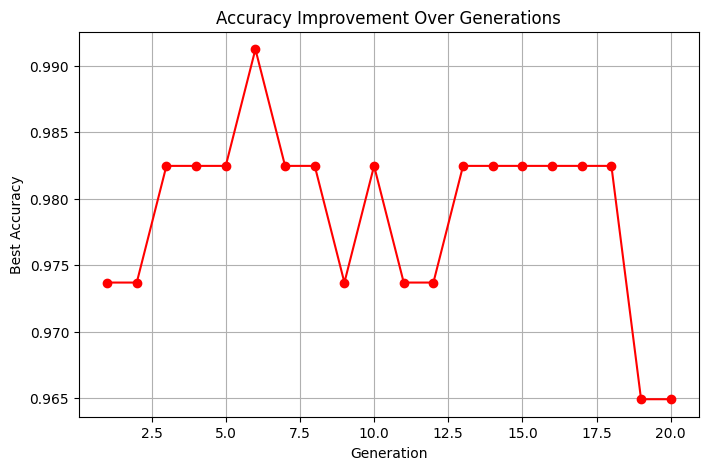

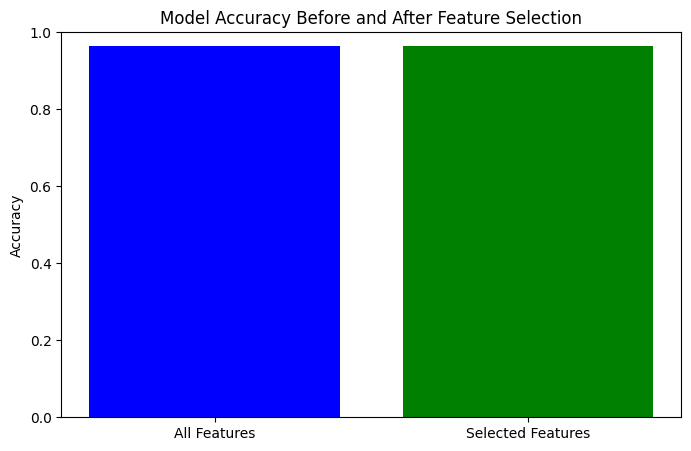

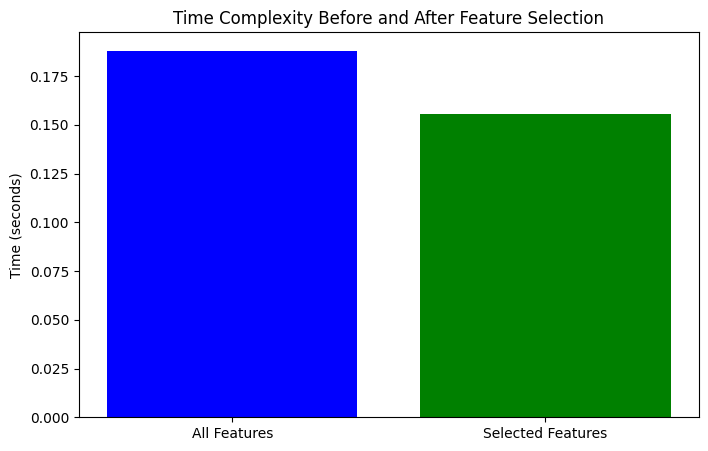

Accuracy with all features: 0.9649
Accuracy with selected features: 0.9649
Time taken with all features: 0.1881 seconds
Time taken with selected features: 0.1554 seconds


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer

def initialize_population(feature_count, pop_size):
    return np.random.randint(2, size=(pop_size, feature_count))

def fitness_function(population, X, y):
    fitness_scores = np.zeros(population.shape[0])
    
    for i, chromosome in enumerate(population):
        selected_features = np.where(chromosome == 1)[0]
        if selected_features.size == 0:
            continue
        
        X_selected = X[:, selected_features]
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        fitness_scores[i] = accuracy_score(y_test, predictions)
    
    return fitness_scores

def select_parents(population, fitness_scores):
    total_fitness = fitness_scores.sum()
    if total_fitness == 0:
        return population[np.random.choice(len(population), 2, replace=False)]
    
    selection_probs = fitness_scores / total_fitness
    return population[np.random.choice(len(population), 2, replace=False, p=selection_probs)]

def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1))
    child1 = np.concatenate((parent1[:point], parent2[point:]))
    child2 = np.concatenate((parent2[:point], parent1[point:]))
    return child1, child2

def mutate(population, mutation_rate):
    mutation_mask = np.random.rand(*population.shape) < mutation_rate
    return np.logical_xor(population, mutation_mask).astype(int)

def genetic_algorithm(X, y, feature_count, pop_size=10, generations=20, mutation_rate=0.1):
    population = initialize_population(feature_count, pop_size)
    best_fitness_per_generation = []
    selected_features_per_generation = []
    
    for generation in range(generations):
        fitness_scores = fitness_function(population, X, y)
        best_fitness_per_generation.append(np.max(fitness_scores))
        
        best_index = np.argmax(fitness_scores)
        selected_features = np.where(population[best_index] == 1)[0]
        selected_features_per_generation.append(selected_features)
        
        new_population = []
        for _ in range(pop_size // 2):
            parent1, parent2 = select_parents(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([child1, child2])
        
        population = mutate(np.array(new_population), mutation_rate)
        print(f"Generation {generation + 1}: Best Fitness = {fitness_scores[best_index]:.4f}")
        print(f"Selected Features: {selected_features}")
    
    best_solution = population[np.argmax(fitness_scores)]
    print("\nBest Feature Subset:", best_solution)
    
    # Plot accuracy improvement over generations
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, generations + 1), best_fitness_per_generation, marker='o', linestyle='-', color='red')
    plt.xlabel("Generation")
    plt.ylabel("Best Accuracy")
    plt.title("Accuracy Improvement Over Generations")
    plt.grid()
    plt.show()
    
    return best_solution, selected_features_per_generation

def evaluate_model(X, y, selected_features):
    X_train, X_test, y_train, y_test = train_test_split(X[:, selected_features], y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)

if __name__ == "__main__":
    data = load_breast_cancer()
    X, y = data.data, data.target
    feature_count = X.shape[1]
    
    # Measure time for full feature model
    start_time = time.time()
    full_feature_accuracy = evaluate_model(X, y, np.arange(feature_count))
    full_feature_time = time.time() - start_time
    
    # Run Genetic Algorithm
    best_features, selected_features_per_generation = genetic_algorithm(X, y, feature_count)
    selected_feature_indices = np.where(best_features == 1)[0]
    
    # Measure time for reduced feature model
    start_time = time.time()
    reduced_feature_accuracy = evaluate_model(X, y, selected_feature_indices)
    reduced_feature_time = time.time() - start_time
    
    # Plot accuracy comparison
    plt.figure(figsize=(8, 5))
    plt.bar(["All Features", "Selected Features"], [full_feature_accuracy, reduced_feature_accuracy], color=["blue", "green"])
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Before and After Feature Selection")
    plt.ylim(0, 1)
    plt.show()
    
    # Plot time complexity comparison
    plt.figure(figsize=(8, 5))
    plt.bar(["All Features", "Selected Features"], [full_feature_time, reduced_feature_time], color=["blue", "green"])
    plt.ylabel("Time (seconds)")
    plt.title("Time Complexity Before and After Feature Selection")
    plt.show()
    
    print(f"Accuracy with all features: {full_feature_accuracy:.4f}")
    print(f"Accuracy with selected features: {reduced_feature_accuracy:.4f}")
    print(f"Time taken with all features: {full_feature_time:.4f} seconds")
    print(f"Time taken with selected features: {reduced_feature_time:.4f} seconds")
